In [ ]:
!pip install eo-learn -q

     |████████████████████████████████| 10.5 MB 3.7 MB/s 
     |████████████████████████████████| 69 kB 6.2 MB/s 
     |████████████████████████████████| 1.0 MB 69.0 MB/s 
     |████████████████████████████████| 201 kB 58.9 MB/s 
     |████████████████████████████████| 131 kB 64.3 MB/s 
     |████████████████████████████████| 133 kB 67.2 MB/s 
     |████████████████████████████████| 53.8 MB 118 kB/s 
     |████████████████████████████████| 19.3 MB 364 kB/s 
     |████████████████████████████████| 15.4 MB 45.6 MB/s 
     |████████████████████████████████| 994 kB 47.8 MB/s 
     |████████████████████████████████| 6.3 MB 55.2 MB/s 
     |████████████████████████████████| 3.1 MB 44.6 MB/s 
     |████████████████████████████████| 8.4 MB 42.5 MB/s 
     |████████████████████████████████| 128 kB 58.2 MB/s 
     |████████████████████████████████| 79 kB 274 kB/s 
     |████████████████████████████████| 127 kB 32.1 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |█████████████

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import cv2
import eolearn
import gdown
from pathlib import Path
import zipfile

from eolearn.core import EOPatch, FeatureType

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive #a
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Гиперпараметры

In [ ]:
TARGET_SIZE = (64, 64)
DATA_PATH = '/content/spills'

# Загрузка архива

### Разливы

In [ ]:
INPUT_FOLDER =  '/content/drive/MyDrive/colab_files/final/spills/'

for file_name in os.listdir(INPUT_FOLDER):
    with zipfile.ZipFile(INPUT_FOLDER + file_name) as zip_ref:
        zip_ref.extractall("spills")

In [ ]:
def renamed(dirpath, names, encoding):
        new_names = [old.encode('cp437').decode(encoding) for old in names]
        for old, new in zip(names, new_names):
                os.rename(os.path.join(dirpath, old), os.path.join(dirpath, new))
        return new_names

encoding = 'cp866'
for dirpath, dirs, files in os.walk('spills', topdown=True):
        renamed(dirpath, files, encoding)
        dirs[:] = renamed(dirpath, dirs, encoding)



### СSV

In [ ]:
file_id = '1Eo08JT3zZT8nktTE2Wwqfwng4bpbnNGU'
filename = gdown.download('https://drive.google.com/uc?id={}'.format(file_id), None, False)

Downloading...
From: https://drive.google.com/uc?id=1Eo08JT3zZT8nktTE2Wwqfwng4bpbnNGU
To: /content/clean_pollution.csv
100%|██████████| 1.72M/1.72M [00:00<00:00, 148MB/s]


In [ ]:
file_id = '1-0KypqrB6uoD9xZyYaPGHqQ94hSSW1Mn'
filename = gdown.download('https://drive.google.com/uc?id={}'.format(file_id), None, False)

Downloading...
From: https://drive.google.com/uc?id=1-0KypqrB6uoD9xZyYaPGHqQ94hSSW1Mn
To: /content/clean_pollution_w_names_n_idx_2021.csv
100%|██████████| 80.1k/80.1k [00:00<00:00, 20.6MB/s]


In [ ]:
file_id = '1EqsaKDXplnGdPG0qaa_JX25qnaHz-Yqb'
gdown.download('https://drive.google.com/uc?id={}'.format(file_id), None, False)

# Сборка датасета

## Функции

In [ ]:
# ЛУК-2020-1	15.0	0,1,2,3,4,

def prepare_batch(filename, id_max, idx):
    proto_idx = tf.make_tensor_proto(idx)
    idx = tf.make_ndarray(proto_idx)
    idx = [int(i) for i in idx[0].decode().split(',')[:-1]]
    lbls = []
    id_max = int(float(id_max))
    for i in range(id_max + 1):
        if i in idx:
            lbls.append(1.)
        else:
            lbls.append(0.)
    return filename, tf.expand_dims(lbls, -1)

prepare_batch(tf.Variable('ЛУК-2020-1'), tf.Variable(['15.0']), tf.Variable(['2,3,4,10,']))

(<tf.Variable 'Variable:0' shape=() dtype=string, numpy=b'\xd0\x9b\xd0\xa3\xd0\x9a-2020-1'>,
 <tf.Tensor: shape=(16, 1), dtype=float32, numpy=
 array([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)>)

In [ ]:
def read_file(item, label, shuffle=True):
    try:
        eopatch = EOPatch.load(item[0].numpy().decode())
        img = eopatch.data['L2A']
        masks = [eopatch.mask[x] for x in eopatch.mask]
        # if shuffle:
        #     idx = np.random.choice(len(img), len(img), replace=False)astype('int')
        #     img = img[idx]
        #     masks = masks[idx]
        return np.concatenate([img] + masks, axis=-1), label
    except:
        return tf.zeros(shape=(1, 64, 64, 19)), tf.zeros(shape=(1, 1))

In [ ]:
@tf.function()
def augmentation(img, label):
    '''
    Случайное вращение и отражение изображения для аугментации
    '''
    if tf.random.uniform(()) > 0.5:
    # Случайное отражение по горизонтали
        img = tf.image.flip_left_right(img)

    if tf.random.uniform(()) > 0.5:
    # Случайное отражение по вертикали
        img = tf.image.flip_up_down(img)

    if tf.random.uniform(()) > 0.5:
    # Случайное транспонирование
        img = tf.image.transpose(img)

    # if tf.random.uniform(()) > 0.5:
    #     # Вращение
    #     img = rotation(img)

    if tf.random.uniform(()) > 0.1:
    # Зашумление картинки
        img = tf.cast(img, tf.float32) + tf.random.uniform((tf.shape(img)), tf.random.uniform((), .3, .8), 0.99)

    return img, label

## Датасет

In [ ]:
df = pd.read_csv('/content/clean_pollution_w_names_n_idx_2021.csv')
df.head()

,Unnamed: 0,cat_pollution,lat,lon,date,cat_ground,square,filename,idx_max,idx
0,3,нефть,73.547472,62.557611,2021-02-18 00:00:00,земли лесного фонда,0.0100,ЛУК-КГ-2020-1,18.0,"0,1,"
1,4,нефть,73.983397,62.129353,2021-02-18 00:00:00,земли лесного фонда,0.0050,ЛУК-КГ-2020-2,17.0,"0,"
2,40,нефтепродукты,61.043514,63.788392,2021-02-18 00:00:00,земли лесного фонда,0.0064,ЛУК-2020-1,15.0,"0,1,2,3,4,"
3,46,нефть,65.139139,61.272858,2021-02-12 00:00:00,земли лесного фонда,0.0553,ЛУК-2020-2,38.0,"2,3,4,5,6,"
4,52,нефтепродукты,61.297472,64.450694,2021-02-12 00:00:00,земли лесного фонда,0.0059,ЛУК-2020-3,9.0,"0,1,2,3,"


In [ ]:
df_path = pd.read_csv('/content/files_pollution.csv', index_col=0)
df_path.head()

,year,dir,name,date,id_pollution,path
0,2017.0,1,ЛУК-2016-6,2017-02-15 00:00:00,0,2017-01/ЛУК-2016-6
1,2017.0,1,ЛУК-2016-7,2017-02-15 00:00:00,1,2017-01/ЛУК-2016-7
2,2019.0,1,ЛУК-КГ-2018-1,2019-03-04 00:00:00,2,2019-01/ЛУК-КГ-2018-1
3,2021.0,1,ЛУК-КГ-2020-1,2021-02-18 00:00:00,3,2021-01/ЛУК-КГ-2020-1
4,2021.0,1,ЛУК-КГ-2020-2,2021-02-18 00:00:00,4,2021-01/ЛУК-КГ-2020-2


In [ ]:
all_filenames = glob.glob('/content/spills/*/*')

In [ ]:
all_filenames[0]

'/content/spills/2021-04/РН-СНГ-2013-5116'

In [ ]:
len(all_filenames)

11100

In [ ]:
data_names = []
data_idx = []
data_idx_max = []

for i in range(len(df)):
    filename = df.iloc[i]['filename']
    idx = df.iloc[i]['idx']
    idx_max = df.iloc[i]['idx_max']

    for name in all_filenames:
        if filename + ' ' in name + ' ':
            data_names.append(name)
            data_idx.append(idx)
            data_idx_max.append(idx_max)

In [ ]:
len(data_names), len(data_idx), len(data_idx_max)

(461, 461, 461)

In [ ]:
val_split = 400

dataset_names = tf.data.Dataset.from_tensor_slices(data_names[:val_split])
dataset_idx = tf.data.Dataset.from_tensor_slices(data_idx[:val_split])
dataset_idx_max = tf.data.Dataset.from_tensor_slices(data_idx_max[:val_split])

val_dataset_names = tf.data.Dataset.from_tensor_slices(data_names[val_split:])
val_dataset_idx = tf.data.Dataset.from_tensor_slices(data_idx[val_split:])
val_dataset_idx_max = tf.data.Dataset.from_tensor_slices(data_idx_max[val_split:])

dataset = tf.data.Dataset.zip((dataset_names, dataset_idx_max, dataset_idx)).shuffle(512).batch(1)
val_dataset = tf.data.Dataset.zip((val_dataset_names, val_dataset_idx_max, val_dataset_idx)).shuffle(512).batch(1)

# prepare_batch(filename, id_max, idx)
dataset = dataset.map(
        lambda filename, id_max, idx: tuple(tf.py_function(prepare_batch,
                                                            [filename, id_max, idx], 
                                                            [tf.string, tf.float32])))
val_dataset = val_dataset.map(
        lambda filename, id_max, idx: tuple(tf.py_function(prepare_batch,
                                                            [filename, id_max, idx], 
                                                            [tf.string, tf.float32])))

# функция подгрузки изображений
dataset = dataset.map(
        lambda item, label: tuple(tf.py_function(read_file, [item, label], [tf.float32, tf.float32])))
val_dataset = val_dataset.map(
        lambda item, label: tuple(tf.py_function(read_file, [item, label], [tf.float32, tf.float32])))

# слой вращения
rotation = layers.experimental.preprocessing.RandomRotation(factor=0.07)

# функция аугментации изображений
dataset = dataset.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)

for i, batch in enumerate(val_dataset):
    print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    if i > 4:
        break

2
(17, 64, 64, 19)
(17, 1)
2
(24, 64, 64, 19)
(24, 1)
2
(10, 64, 64, 19)
(10, 1)
2
(10, 64, 64, 19)
(10, 1)
2
(10, 64, 64, 19)
(10, 1)
2
(17, 64, 64, 19)
(17, 1)


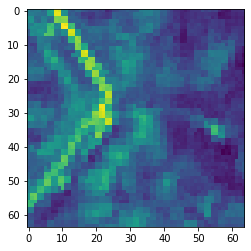

In [ ]:
plt.imshow(batch[0][0, ..., 4])
plt.show()

In [ ]:
model(batch[0], training=False)

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [ ]:
x, y = batch
with tf.GradientTape() as tape:
    y_pred = model(x, training=True)  # Forward pass
    # Compute the loss value
    # (the loss function is configured in `compile()`)
    loss = tf.keras.losses.binary_crossentropy(y, y_pred)
    print(loss)


tf.Tensor(
[5421.352  5269.009  5419.6333 6094.307     0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.    ], shape=(20,), dtype=float32)


# NN

### Simple test nn

In [ ]:
inputs = layers.Input((64, 64, 19))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(32, 3, strides=2, activation='relu')(x)
x = layers.Conv2D(32, 2, activation='relu')(x)
x = layers.Conv2D(32, 2, strides=2, activation='relu')(x)
x = layers.Conv2D(32, 2, activation='relu')(x)
x = layers.Conv2D(32, 2, strides=2, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# model = CustomModel(inputs, outputs)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy')

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.Accuracy(name="accuracy")
    ],
)


In [ ]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 19)]      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 62, 62, 32)        5504      
                                                                 
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 conv2d_33 (Conv2D)          (None, 29, 29, 32)        4128      
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 32)        4128      
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 32)        4128      
                                                                 
 conv2d_36 (Conv2D)          (None, 6, 6, 32)          412

In [ ]:
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=5,
)

Epoch 1/5
400/400 [==============================] - 63s 153ms/step - loss: 1.5311 - accuracy: 0.8865 - val_loss: 2.2852 - val_accuracy: 0.8403
Epoch 2/5
400/400 [==============================] - 60s 151ms/step - loss: 1.5337 - accuracy: 0.8949 - val_loss: 2.2852 - val_accuracy: 0.8403


KeyboardInterrupt: ignored

In [ ]:
model.evaluate(val_dataset)

61/61 [==============================] - 6s 105ms/step - loss: 2.2852 - accuracy: 0.8403


[2.2851786613464355, 0.8403292298316956]

## CCT

### Гиперпараметры

In [ ]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 64
input_shape = [64, 64, 19]

### Токенайзер

In [ ]:

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # После прохождения данной мини-сетки изображение превращается в ряд последовательностей
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Опциональная часть с позиционным эмбеддингом
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None


### Stochastic depth

[Stochastic depth](https://arxiv.org/abs/1603.09382) -
техника регуляризации, которая случайным образом блокирует работу некоторых слоев нейросети. По смыслу близка к "дропауту" - [Dropout](https://jmlr.org/papers/v15/srivastava14a.html), с той разницей, что дропаут блокирует отдельные нейроны.

In [ ]:
# Источник: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


### multilayer perceptron (MLP) для энкодера трансформера

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


### Финальная сборка модели

In [ ]:

def create_cct_model(
    input_shape=input_shape,
    image_size=image_size,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Кодирование (нарезка) патчей.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Применение позиционного эмбеддинга.
    
    # Stochastic Depth
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Блоки трансформера.
    for i in range(transformer_layers):
        # Нормализация.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Self-Attention-блок.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip-connection.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Нормализация.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip-connection.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Применение sequence pooling для получения взвешенного выхода сети.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1,)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Выход классификатора.
    logits = layers.Dense(1,  activation='sigmoid')(weighted_representation)
    # Готовая модель
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Обучение

In [ ]:
model = create_cct_model(input_shape = [64, 64, 19])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.Accuracy(name="accuracy")
    ],
)


In [ ]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 64, 64, 19)  0           []                               
                                ]                                                                 
                                                                                                  
 cct_tokenizer_7 (CCTTokenizer)  (None, 256, 128)    84672       ['input_19[0][0]']               
                                                                                                  
 layer_normalization_35 (LayerN  (None, 256, 128)    256         ['cct_tokenizer_7[0][0]']        
 ormalization)                                                                                    
                                                                                           

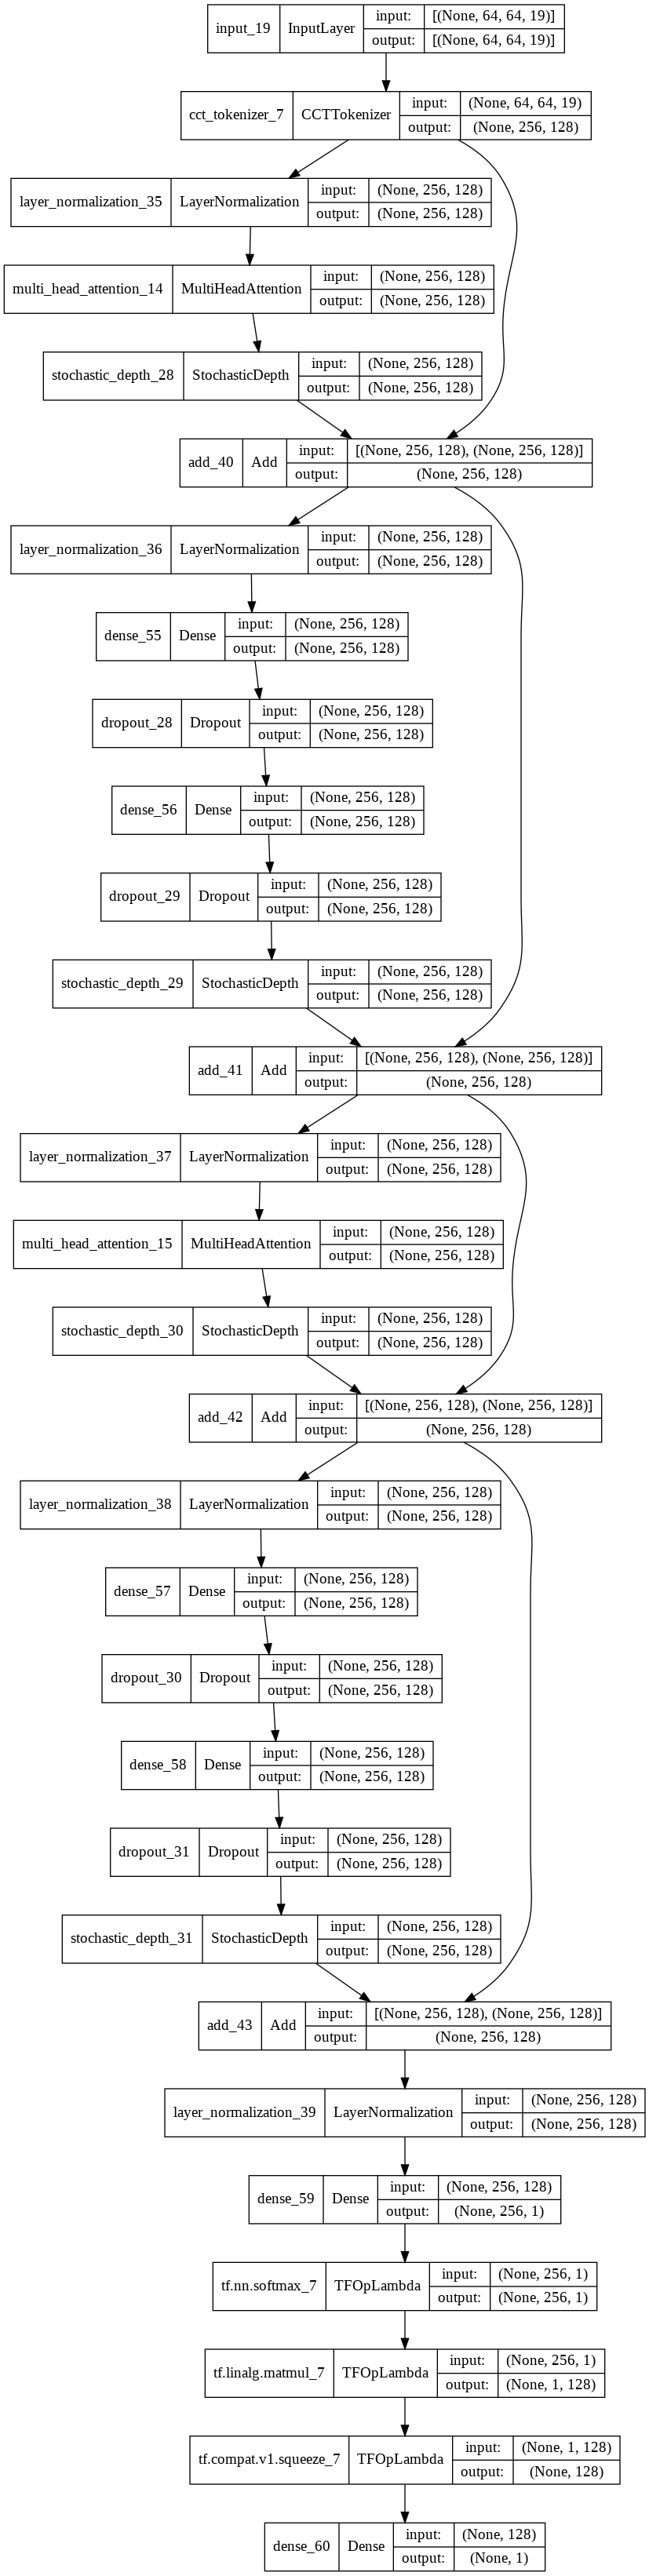

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
)

Epoch 1/30
400/400 [==============================] - 40s 88ms/step - loss: 0.2475 - accuracy: 0.8906 - val_loss: 0.3113 - val_accuracy: 0.8519
Epoch 2/30
400/400 [==============================] - 34s 86ms/step - loss: 0.2150 - accuracy: 0.8999 - val_loss: 0.3200 - val_accuracy: 0.8519
Epoch 3/30
400/400 [==============================] - 34s 85ms/step - loss: 0.2075 - accuracy: 0.9042 - val_loss: 0.2697 - val_accuracy: 0.8757
Epoch 4/30
400/400 [==============================] - 87s 219ms/step - loss: 0.1973 - accuracy: 0.9115 - val_loss: 0.3207 - val_accuracy: 0.8519
Epoch 5/30
400/400 [==============================] - 35s 86ms/step - loss: 0.1780 - accuracy: 0.9292 - val_loss: 0.2564 - val_accuracy: 0.8864
Epoch 6/30
400/400 [==============================] - 34s 86ms/step - loss: 0.1858 - accuracy: 0.9160 - val_loss: 0.2822 - val_accuracy: 0.8790
Epoch 7/30
400/400 [==============================] - 34s 85ms/step - loss: 0.1647 - accuracy: 0.9364 - val_loss: 0.2728 - val_accuracy

In [ ]:
model.evaluate(val_dataset)

61/61 [==============================] - 5s 85ms/step - loss: 0.3098 - accuracy: 0.8626


[0.3098328113555908, 0.8625514507293701]

In [ ]:
for i, batch in enumerate(val_dataset):
    print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    if i > 4:
        break

2
(18, 64, 64, 19)
(18, 1)
2
(10, 64, 64, 19)
(10, 1)
2
(16, 64, 64, 19)
(16, 1)
2
(30, 64, 64, 19)
(30, 1)
2
(18, 64, 64, 19)
(18, 1)
2
(17, 64, 64, 19)
(17, 1)


In [ ]:
print(batch[0].shape, batch[1])
model(batch[0])

(17, 64, 64, 19) tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(17, 1), dtype=float32)


<tf.Tensor: shape=(17, 1), dtype=float32, numpy=
array([[1.7676784e-02],
       [3.3280898e-02],
       [3.8636666e-02],
       [2.8540608e-02],
       [2.5634742e-01],
       [8.3175009e-01],
       [8.9657897e-01],
       [1.1643028e-01],
       [8.2050361e-02],
       [9.2075042e-02],
       [9.3884650e-05],
       [1.0346603e-04],
       [1.2131853e-04],
       [1.4782466e-04],
       [3.0185503e-04],
       [2.9993814e-04],
       [5.6857319e-04]], dtype=float32)>

In [ ]:
model.load_weights('CCT.h5')

In [ ]:
!zip -r CCT-inference.zip /content/spills/2021-01/КБ-2020-1 



zip error: Interrupted (aborting)


In [ ]:
inputs = layers.Input((64, 64, 19))
x = layers.Resizing(71, 71)(inputs)
model = tf.keras.applications.Xception( include_top=True, input_tensor=x, weights=None)